In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smt

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import pearsonr

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE, annotate_pval, mimic_r_boxplot


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
from data_loading import (load_annotated_6k_collection,
                          load_annotated_gencode_tfs,
                          load_valid_isoform_clones,
                          load_developmental_tissue_expression_gencode)

In [4]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [5]:
pal = {"ref": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray"}

## variables

In [6]:
dn_data_f = "../data/processed/DN_cats_Joung.tsv"

In [7]:
brca_cnts_f = "../data/processed/Nathans_analysis/Breast_cancer/isoCounts.BreastCancer.txt"
brca_tx_f = "../data/processed/Nathans_analysis/Breast_cancer/transcript.BreastCancer.txt"
pam50_f = "../data/processed/Nathans_analysis/Breast_cancer/groups.PAM50.txt"
bulk_f = "../data/processed/Nathans_analysis/Breast_cancer/groups.BreastCancer_ratios.txt"

## 1. import data

In [8]:
dn_data = pd.read_table(dn_data_f)
dn_data.head()

,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,match_type,joung_id,enst,seq_aa_tf1p0,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len
0,ZBTB18,C2H2 ZF,ZBTB18|1/2|04E08,False,True,ref,ref,Genewiz,TFORF2495,ZBTB18,...,seq_aa,TFORF2495,['ENST00000358704'],MCPKGYEDSMEFPDHSRHLLQCLSEQRHQGFLCDCTVLVGDAQFRA...,TFORF2495-ZBTB18,1.725205e-01,0.002115,0.168074,-0.004946,531.0
1,PRRX1,Homeodomain,PRRX1|2/3|09F06,False,True,ref,ref,Genewiz,TFORF1217,PRRX1,...,seq_aa,TFORF1217,['ENST00000239461'],MTSSYGHVLERQPALGGRLDSPGNLDTLQAKKNFSVSHLLDLEEAG...,TFORF1217-PRRX1,3.652862e-01,0.000400,0.000021,-0.009730,245.0
2,POU2F1,Homeodomain; POU,POU2F1|2/2|04D01,False,False,ref,ref,Broad GPP,TFORF3019,POU2F1,...,seq_aa,TFORF3019,['ENST00000541643'],MNNPSETSKPSMESGDGNTGTQTNGLDFQKQPVPVGGAISTAQAQA...,TFORF3019-POU2F1,4.562077e-01,0.001600,0.023410,-0.012525,743.0
3,ATF3,bZIP,ATF3|1/2|08B04,False,True,ref,ref,Genewiz,TFORF0801,ATF3,...,seq_aa,TFORF0801,"['ENST00000341491', 'ENST00000366987']",MMLQHPGQVSASEVSASAIVPCLSPPGSLVFEDFANLTPFVKEELR...,TFORF0801-ATF3,1.179785e-03,0.002153,0.000246,-0.004118,181.0
4,GRHL3,Grainyhead,GRHL3|3/7|08G09,False,True,ref,ref,Genewiz,TFORF2165,GRHL3,...,seq_aa,TFORF2165,['ENST00000361548'],MSNELDFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLTAATKA...,TFORF2165-GRHL3,2.270000e-07,-0.030514,0.000001,-0.039517,602.0


In [9]:
skiprows=list(range(96320, 96387))+list(range(99680,99687))
brca = pd.read_table(brca_tx_f, sep="\t", skiprows=skiprows)
brca.shape

(99774, 1223)

In [10]:
pam50_samps = pd.read_table(pam50_f, header=None)
pam50_samps.columns = ["file", "samp_type_id", "samp_type"]
pam50_samps["tcga_id"] = pam50_samps["file"].str.split(".", expand=True)[0]
pam50_samps.samp_type.value_counts()

Luminal A        232
Luminal B        125
controls         119
Basal-like       101
HER2-enriched     58
Normal-like        8
Name: samp_type, dtype: int64

In [11]:
bulk_samps = pd.read_table(bulk_f, header=None)
bulk_samps.columns = ["file", "samp_type_id", "samp_type"]
bulk_samps["tcga_id"] = bulk_samps["file"].str.split(".", expand=True)[0]
bulk_samps.samp_type.value_counts()

BC          1104
controls     119
Name: samp_type, dtype: int64

## 2. map sample types

In [12]:
brca_samps = list(bulk_samps[bulk_samps["samp_type"] != "controls"]["tcga_id"])
print("# breast cancer samples: %s" % len(brca_samps))


# same ctrls in both
ctrl_samps = list(pam50_samps[pam50_samps["samp_type"] == "controls"]["tcga_id"])
print("# control samples: %s" % len(ctrl_samps))

luma_samps = list(pam50_samps[pam50_samps["samp_type"] == "Luminal A"]["tcga_id"])
print("# Luminal A samples: %s" % len(luma_samps))

lumb_samps = list(pam50_samps[pam50_samps["samp_type"] == "Luminal B"]["tcga_id"])
print("# Luminal B samples: %s" % len(lumb_samps))

tn_samps = list(pam50_samps[pam50_samps["samp_type"] == "Basal-like"]["tcga_id"])
print("# Basal-like samples: %s" % len(tn_samps))

her2_samps = list(pam50_samps[pam50_samps["samp_type"] == "HER2-enriched"]["tcga_id"])
print("# HER2-enriched samples: %s" % len(her2_samps))

norm_samps = list(pam50_samps[pam50_samps["samp_type"] == "Normal-like"]["tcga_id"])
print("# Normal-like samples: %s" % len(norm_samps))

# breast cancer samples: 1104
# control samples: 119
# Luminal A samples: 232
# Luminal B samples: 125
# Basal-like samples: 101
# HER2-enriched samples: 58
# Normal-like samples: 8


In [13]:
# one brca samp is weirdly missing, remove
brca_samps = [x for x in brca_samps if x in brca.columns]
len(brca_samps)

1103

In [14]:
## patient is the 3rd value in the barcode
## source: https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
bulk_samps["patient_id"] = bulk_samps["tcga_id"].str.split("-", expand=True)[2]
pam50_samps["patient_id"] = pam50_samps["tcga_id"].str.split("-", expand=True)[2]

In [15]:
tcga_samps = bulk_samps.merge(pam50_samps, on=["tcga_id", "patient_id"], how="outer",
                              suffixes=("_brca", "_pam50"))
print(len(tcga_samps))

1223


In [16]:
tcga_ctrls = tcga_samps[(tcga_samps["samp_type_brca"] == "controls") | (tcga_samps["samp_type_pam50"] == "controls")]
len(tcga_ctrls)

119

In [17]:
tcga_tumors = tcga_samps[(tcga_samps["samp_type_brca"] != "controls") | (tcga_samps["samp_type_pam50"] != "controls")]
len(tcga_tumors)

1104

In [18]:
tcga_paired = tcga_ctrls.merge(tcga_tumors, on=["patient_id"], suffixes=("_ctrl", "_tumor"))
print(len(tcga_paired))

123


## 3. aggregate TF iso expression across transcripts

In [19]:
tfs = load_annotated_6k_collection()

reading from cache


In [20]:
tf_id_map = pd.DataFrame()
gene_names = []
iso_ids = []
clone_accs = []
enst_ids = []

for tf in tfs:
    db = tfs[tf]
    for iso in db.orfs:
        enst_id = iso.ensembl_transcript_ids
        try:
            clone_acc = iso.clone_acc
        except:
            clone_acc = "none"
        
        if enst_id is None:
            gene_names.append(tf)
            iso_ids.append(iso.name)
            clone_accs.append(clone_acc)
            enst_ids.append("none")
        else:
            for enst_id in iso.ensembl_transcript_ids:
                gene_names.append(tf)
                iso_ids.append(iso.name)
                clone_accs.append(clone_acc)
                enst_ids.append(enst_id)

tf_id_map["gene_name"] = gene_names
tf_id_map["iso_id"] = iso_ids
tf_id_map["clone_acc"] = clone_accs
tf_id_map["enst_id"] = enst_ids
print(len(tf_id_map))
tf_id_map.sample(5)

1665


,gene_name,iso_id,clone_acc,enst_id
723,TCF7L2,TCF7L2-2,TCF7L2|2/14|04F11,none
647,ZNF250,ZNF250-201,none,ENST00000292579
1576,ZNF433,ZNF433-2,ZNF433|2/2|06G02,ENST00000419886
1213,STAT3,STAT3-2,STAT3|2/3|08A06,ENST00000585517
276,ZNF148,ZNF148-201,none,ENST00000484491


In [21]:
def merge_id(row):
    if row.enst_id == "none":
        return row.clone_acc
    else:
        return row.enst_id
    
tf_id_map["merge_id"] = tf_id_map.apply(merge_id, axis=1)
tf_id_map.sample(5)

,gene_name,iso_id,clone_acc,enst_id,merge_id
255,RARB,RARB-2,RARB|2/2|08B05,ENST00000437042,ENST00000437042
1426,ZNF559,ZNF559-1,ZNF559|1/3|12E03,ENST00000393883,ENST00000393883
1182,RARA,RARA-1,RARA|1/2|11B12,ENST00000394089,ENST00000394089
1297,ZNF397,ZNF397-4,ZNF397|4/5|08G07,ENST00000585800,ENST00000585800
156,E2F6,E2F6-1,E2F6|1/2|10C02,ENST00000381525,ENST00000381525


In [22]:
dd = tf_id_map[["iso_id", "gene_name"]].drop_duplicates()
print(len(dd))
gene_dict = {row.iso_id : row.gene_name for i, row in dd.iterrows()}

1376


In [23]:
brca_cols = [x for x in brca.columns if x != "UID"]
len(brca_cols)

1222

In [24]:
brca = brca.merge(tf_id_map, left_on="UID", right_on="merge_id")
len(brca)

1664

In [25]:
brca_isos = brca.groupby("iso_id")[brca_cols].agg("sum").reset_index()
len(brca_isos)

1375

In [26]:
brca_isos.head()

,iso_id,TCGA-AC-A3QP-01A-11R-A22U-07,TCGA-BH-A0HB-01A-11R-A056-07,TCGA-B6-A0RM-01A-11R-A084-07,TCGA-A2-A25F-01A-11R-A169-07,TCGA-AN-A03X-01A-21R-A00Z-07,TCGA-A2-A25D-01A-12R-A16F-07,TCGA-D8-A3Z6-01A-11R-A239-07,TCGA-BH-A0W5-01A-11R-A109-07,TCGA-AO-A03V-01A-11R-A115-07,...,TCGA-AR-A24N-01A-11R-A169-07,TCGA-B6-A0WT-01A-11R-A109-07,TCGA-A7-A3IY-01A-21R-A21T-07,TCGA-AR-A5QM-01A-11R-A27Q-07,TCGA-BH-A1FU-11A-23R-A14D-07,TCGA-BH-A0DH-11A-31R-A089-07,TCGA-E2-A10E-01A-21R-A10J-07,TCGA-E9-A1ND-11A-43R-A144-07,TCGA-A8-A09K-01A-11R-A00Z-07,TCGA-A8-A0AD-01A-11R-A056-07
0,AEBP2-2,0.00000,0.000000,0.884969,1.814470,0.887561,0.378890,1.651040,1.77029,0.000000,...,0.476599,0.00000,0.077865,0.000000,3.97740,0.00000,0.034021,0.00000,3.835620,0.00000
1,AEBP2-201,1.26676,2.019730,3.588720,4.549070,1.473740,1.507640,2.665370,2.03800,4.031440,...,2.594580,3.15962,2.871930,2.583600,4.03035,1.48186,3.609680,1.49766,2.255110,3.88637
2,AEBP2-202,2.69345,3.795300,4.965690,8.475100,4.661620,3.247560,3.662790,5.34347,6.067000,...,5.662630,6.32062,6.833820,4.634820,4.43878,2.51768,8.357350,3.30786,1.655240,9.15609
3,AEBP2-204,0.00000,0.503578,0.031885,0.011918,0.000000,0.016137,0.000000,0.00000,0.035119,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.17198,0.104846,0.00000
4,AEBP2-207,0.00000,0.946881,3.609280,13.282700,4.174560,0.431527,0.344149,2.18314,3.986220,...,5.934700,7.72157,0.000000,0.798722,11.54100,4.04379,7.513020,0.00000,6.482200,6.27588


## 4. calculate isoform ratios

In [27]:
# calculate isoform ratios, set anything w gene-level exp <= 1 to nan
brca_genes = pd.Series(index=brca_isos.iso_id, data=brca_isos.iso_id.map(gene_dict).values)

brca_idx = brca_isos.set_index("iso_id", inplace=False)
brca_idx = brca_idx[brca_cols]
brca_gene_sum = brca_idx.groupby(brca_genes).transform('sum')

f_brca = brca_idx/brca_gene_sum
f_brca_nan = f_brca * (brca_gene_sum >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])

## 5. calculate median expression + ratio in each PAM50 type

In [28]:
tcga_paired_ctrls = list(tcga_paired["tcga_id_ctrl"].unique())
tcga_paired_tumors = list(tcga_paired["tcga_id_tumor"].unique())

In [29]:
brca_isos["med_brca_tpm"] = brca_isos[brca_samps].median(axis=1)
brca_isos["med_ctrl_tpm"] = brca_isos[ctrl_samps].median(axis=1)
brca_isos["med_luma_tpm"] = brca_isos[luma_samps].median(axis=1)
brca_isos["med_lumb_tpm"] = brca_isos[lumb_samps].median(axis=1)
brca_isos["med_tn_tpm"] = brca_isos[tn_samps].median(axis=1)
brca_isos["med_her2_tpm"] = brca_isos[her2_samps].median(axis=1)
brca_isos["med_norm_tpm"] = brca_isos[norm_samps].median(axis=1)
brca_isos["med_paired-brca_tpm"] = brca_isos[tcga_paired_tumors].median(axis=1)
brca_isos["med_paired-ctrls_tpm"] = brca_isos[tcga_paired_ctrls].median(axis=1)

In [30]:
f_brca_nan["med_brca_rationan"] = f_brca_nan[brca_samps].median(axis=1)
f_brca_nan["med_ctrl_rationan"] = f_brca_nan[ctrl_samps].median(axis=1)
f_brca_nan["med_luma_rationan"] = f_brca_nan[luma_samps].median(axis=1)
f_brca_nan["med_lumb_rationan"] = f_brca_nan[lumb_samps].median(axis=1)
f_brca_nan["med_tn_rationan"] = f_brca_nan[tn_samps].median(axis=1)
f_brca_nan["med_her2_rationan"] = f_brca_nan[her2_samps].median(axis=1)
f_brca_nan["med_norm_rationan"] = f_brca_nan[norm_samps].median(axis=1)
f_brca_nan["med_paired-brca_rationan"] = f_brca_nan[tcga_paired_tumors].median(axis=1)
f_brca_nan["med_paired-ctrls_rationan"] = f_brca_nan[tcga_paired_ctrls].median(axis=1)

In [31]:
f_brca["med_brca_ratio"] = f_brca[brca_samps].median(axis=1)
f_brca["med_ctrl_ratio"] = f_brca[ctrl_samps].median(axis=1)
f_brca["med_luma_ratio"] = f_brca[luma_samps].median(axis=1)
f_brca["med_lumb_ratio"] = f_brca[lumb_samps].median(axis=1)
f_brca["med_tn_ratio"] = f_brca[tn_samps].median(axis=1)
f_brca["med_her2_ratio"] = f_brca[her2_samps].median(axis=1)
f_brca["med_norm_ratio"] = f_brca[norm_samps].median(axis=1)
f_brca["med_paired-brca_ratio"] = f_brca[tcga_paired_tumors].median(axis=1)
f_brca["med_paired-ctrls_ratio"] = f_brca[tcga_paired_ctrls].median(axis=1)

## 7. calculate expression/ratio change per isoform across paired samps

In [32]:
paired_ctrl_samps = list(tcga_paired["tcga_id_ctrl"])
print(len(paired_ctrl_samps))
paired_tumor_samps = list(tcga_paired["tcga_id_tumor"])
print(len(paired_tumor_samps))

123
123


In [33]:
## calculate p-value using wilcoxon
def paired_pval(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    x = [x for x in x if not pd.isnull(x)]
    y = row[tumor_cols]
    y = [y for y in y if not pd.isnull(y)]
    
    try:
        stat, p = wilcoxon(x, y)
        return p
    except:
        return np.nan
    
## calculate p-value using wilcoxon
def paired_stat(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    y = row[tumor_cols]
    
    try:
        stat, p = wilcoxon(x, y)
        return stat
    except:
        return np.nan

f_brca["wilcox_pval"] = f_brca.apply(paired_pval, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
f_brca["wilcox_stat"] = f_brca.apply(paired_stat, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
print(len(f_brca))

f_brca_filt = f_brca[~pd.isnull(f_brca["wilcox_pval"])]
print(len(f_brca_filt))

f_brca_filt["wilcox_padj"] = smt.multipletests(list(f_brca_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]

f_brca_nan["wilcox_pval"] = f_brca_nan.apply(paired_pval, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
f_brca_nan["wilcox_stat"] = f_brca_nan.apply(paired_stat, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
print(len(f_brca_nan))

f_brca_nan_filt = f_brca_nan[~pd.isnull(f_brca_nan["wilcox_pval"])]
print(len(f_brca_nan_filt))

f_brca_nan_filt["wilcox_padj"] = smt.multipletests(list(f_brca_nan_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]

1375
1204
1375
715


In [34]:
for i, row in tcga_paired.iterrows():
    f_brca_filt["paired-diff_%s_ratio" % (i+1)] = f_brca_filt[row.tcga_id_tumor]-f_brca_filt[row.tcga_id_ctrl]
    f_brca_nan_filt["paired-diff_%s_rationan" % (i+1)] = f_brca_nan_filt[row.tcga_id_tumor].fillna(0)-f_brca_nan[row.tcga_id_ctrl].fillna(0)

In [35]:
paired_ratio_cols = [x for x in f_brca_filt.columns if "paired-diff_" in x]
paired_rationan_cols = [x for x in f_brca_nan_filt.columns if "paired-diff_" in x]

In [36]:
f_brca_filt["med_paired-diff_ratio"] = f_brca_filt[paired_ratio_cols].median(axis=1)
f_brca_nan_filt["med_paired-diff_rationan"] = f_brca_nan_filt[paired_rationan_cols].median(axis=1)

## 6. merge median expression w/ DN cats

In [37]:
f_brca_filt = f_brca_filt.merge(tf_id_map, on="iso_id")
f_brca_nan_filt = f_brca_nan_filt.merge(tf_id_map, on="iso_id")

In [38]:
f_brca_nan_med_cols = ["clone_acc"] + [x for x in f_brca_nan_filt.columns if "med_" in x] + [x for x in f_brca_nan_filt.columns if "wilcox" in x]

In [39]:
f_brca_med_cols = ["clone_acc"] + [x for x in f_brca_filt.columns if "med_" in x] + [x for x in f_brca_filt.columns if "wilcox" in x]

In [40]:
dn_data_exp = dn_data.merge(f_brca_nan_filt[f_brca_nan_med_cols], left_on="tf1p0_id", right_on="clone_acc")
dn_data_exp = dn_data_exp.merge(f_brca_filt[f_brca_med_cols], left_on="tf1p0_id", right_on="clone_acc", 
                                suffixes=("_nan", "")).drop_duplicates()
print(len(dn_data_exp))

334


In [41]:
dn_data_exp["neglog_padj"] = -np.log10(dn_data_exp["wilcox_padj"])
dn_data_exp["neglog_padj_nan"] = -np.log10(dn_data_exp["wilcox_padj_nan"])

## 7. plots

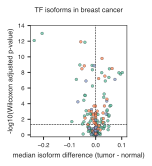

In [42]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_data_exp[dn_data_exp["dn_cat"].isin(["ref", "rewire", "DN"])], 
                     x="med_paired-diff_ratio", y="neglog_padj", 
                     hue="dn_cat", palette=pal, linewidth=0.25, edgecolor="black", alpha=0.8, zorder=10,
                     **{"s": 8})

ax.set_xlabel("median isoform difference (tumor - normal)")
ax.set_ylabel("-log10(Wilcoxon adjusted p-value)")
ax.set_title("TF isoforms in breast cancer\n")

ax.set_xlim((-0.25, 0.12))
ax.set_ylim((-0.25, 14))
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=0.5)
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)

ax.get_legend().remove()

fig.savefig("../figures/BRCA_Volcano.pdf", dpi="figure", bbox_inches="tight")

In [62]:
dn_data_exp[dn_data_exp["gene_name"]=="KLF7"][["tf1p0_id", "dn_cat", "med_paired-diff_ratio", "neglog_padj"]]

,tf1p0_id,dn_cat,med_paired-diff_ratio,neglog_padj
23,KLF7|1/8|01E06,ref,-0.016988,0.091971
194,KLF7|3/8|10B10,rewire,-0.068308,4.239926
195,KLF7|4/8|10E10,DN,0.029539,2.102873
196,KLF7|5/8|11H02,DN,0.002130,1.271087
197,KLF7|6/8|01D06,NaN,0.000000,0.522558
198,KLF7|7/8|10H08,DN,0.000000,0.159276
199,KLF7|8/8|10D09,NaN,0.000000,0.856424


In [81]:
sig = dn_data_exp[["gene_name", "tf1p0_id", "dn_cat", "abs_med_paired-diff_ratio", "neglog_padj"]]
sig["sig"] = dn_data_exp["neglog_padj"] >= -np.log10(0.05)
sig_tot = sig.groupby(["dn_cat"])["tf1p0_id"].agg("count").reset_index()
sig_sig = sig[(sig["sig"]) & 
              (sig["abs_med_paired-diff_ratio"] > 0.05)].groupby(["dn_cat"])["tf1p0_id"].agg("count").reset_index()
sig_low = sig[(sig["sig"]) & 
              (sig["abs_med_paired-diff_ratio"] <= 0.05)].groupby(["dn_cat"])["tf1p0_id"].agg("count").reset_index()
sig_plt = sig_tot.merge(sig_sig, on="dn_cat", suffixes=("_tot", "_sig"), 
                        how="left").merge(sig_low, on="dn_cat", how="left")
sig_plt.fillna(0, inplace=True)
sig_plt["perc_high"] = sig_plt["tf1p0_id_sig"]/sig_plt["tf1p0_id_tot"]
sig_plt["perc_low"] = sig_plt["tf1p0_id"]/sig_plt["tf1p0_id_tot"]
sig_plt["perc_unsig"] = 1-(sig_plt["perc_high"]+sig_plt["perc_low"])
#sig_plt.set_index("dn_cat", inplace=True)
sig_plt = sig_plt[["dn_cat", "perc_high", "perc_low", "perc_unsig"]]
sig_plt

,dn_cat,perc_high,perc_low,perc_unsig
0,DN,0.046875,0.437500,0.515625
1,ref,0.138554,0.259036,0.602410
2,rewire,0.044444,0.222222,0.733333


In [84]:
dn_data_exp[dn_data_exp["dn_cat"].isin(["ref", "rewire", "DN"])][["gene_name", "family", "tf1p0_id",
                                                                  "dn_cat", "med_paired-diff_ratio", 
                                                                  "neglog_padj"]].sort_values(by="neglog_padj", 
                                                                                              ascending=False).head(20)

,gene_name,family,tf1p0_id,dn_cat,med_paired-diff_ratio,neglog_padj
5,NFIA,SMAD,NFIA|2/5|02G09,ref,-0.205456,12.997297
24,TFDP2,E2F,TFDP2|1/4|03C12,ref,-0.235812,12.091513
325,ZBTB25,C2H2 ZF,ZBTB25|4/5|04D09,DN,-0.057185,11.928042
19,STAT1,STAT,STAT1|1/7|01B05,ref,-0.041268,11.861685
18,STAT1,STAT,STAT1|1/7|01B05,ref,-0.041268,11.861685
236,ZNF451,C2H2 ZF,ZNF451|8/8|06F02,DN,0.024408,9.791616
164,PKNOX1,Homeodomain,PKNOX1|1/4|11H11,ref,-0.060639,8.961888
13,ELK4,Ets,ELK4|1/2|07H08,ref,-0.013613,8.901470
229,NFYA,CBF/NF-Y,NFYA|2/3|07G01,rewire,-0.005593,8.858212
430,PATZ1,C2H2 ZF; AT hook,PATZ1|3/4|02A04,DN,-0.043469,8.847031


In [44]:
brca_isos = brca_isos.merge(tf_id_map[["iso_id", "gene_name"]], on="iso_id").drop_duplicates()
len(brca_isos)

1375

In [45]:
brca_isos_paired = brca_isos[["gene_name", "iso_id"] + tcga_paired_ctrls + tcga_paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(tcga_paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(tcga_paired_tumors)]
brca_isos_paired.columns = ["gene_name", "iso_id"] + new_ctrl_cols + new_tumor_cols

In [46]:
def brca_expression_plot(gene_name, figsize, ylim, df, cols, fig_suffix):
    df_sub = df[df["gene_name"] == gene_name]
    df_sub.set_index("iso_id", inplace=True)
    df_sub = df_sub[cols].drop_duplicates()
    #print(df_sub.head())
    n_isos = len(df_sub)
    palette = sns.color_palette("husl", as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (df_sub
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    (df_sub.div(df_sub.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_yscale("symlog")
    axes[0].set_ylabel('tpm')
    #axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../figures/brca_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

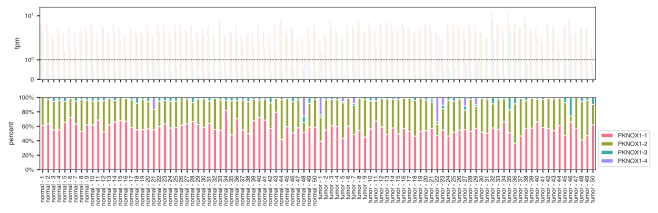

In [47]:
cols = new_ctrl_cols[0:50] + new_tumor_cols[0:50]
brca_expression_plot("PKNOX1", (10, 3), (0, 6), brca_isos_paired, cols, "paired")

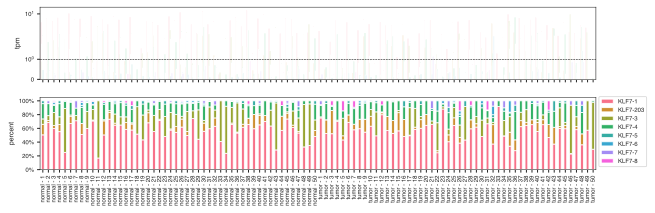

In [48]:
cols = new_ctrl_cols[0:50] + new_tumor_cols[0:50]
brca_expression_plot("KLF7", (10, 3), (0, 6), brca_isos_paired, cols, "paired")

In [49]:
f_brca_paired = f_brca_filt[["gene_name", "iso_id"] + tcga_paired_ctrls + tcga_paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(tcga_paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(tcga_paired_tumors)]
f_brca_paired.columns = ["gene_name", "iso_id"] + new_ctrl_cols + new_tumor_cols

In [50]:
f_brca_paired_melt = pd.melt(f_brca_paired, id_vars=["gene_name", "iso_id"])
f_brca_paired_melt["samp"] = f_brca_paired_melt["variable"].str.split(" ", expand=True)[0]

In [51]:
dn_data_exp = dn_data_exp.merge(tf_id_map[["gene_name", "clone_acc", "iso_id", "merge_id"]], 
                                left_on=["gene_name", "tf1p0_id"],
                                right_on=["gene_name", "clone_acc"]).drop_duplicates()
print(len(dn_data_exp))
dn_data_exp[dn_data_exp["gene_name"]=="PKNOX1"]

431


,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,med_paired-ctrls_ratio,med_paired-diff_ratio,wilcox_pval,wilcox_stat,wilcox_padj,neglog_padj,neglog_padj_nan,clone_acc_y,iso_id,merge_id
164,PKNOX1,Homeodomain,PKNOX1|1/4|11H11,False,True,ref,ref,Broad GPP,TFORF3468,PKNOX1,...,0.620462,-0.060639,2.629562e-11,1172.0,1.091721e-09,8.961888,9.106022,PKNOX1|1/4|11H11,PKNOX1-1,ENST00000291547
426,PKNOX1,Homeodomain,PKNOX1|2/4|06H05,True,False,DN,alt,NaN,NaN,NaN,...,0.340229,0.063234,9.696959e-11,1249.0,3.155443e-09,8.500940,8.650420,PKNOX1|2/4|06H05,PKNOX1-2,PKNOX1|2/4|06H05
427,PKNOX1,Homeodomain,PKNOX1|3/4|06H03,False,False,DN,alt,Genewiz,TFORF1274,PKNOX1,...,0.036398,-0.009123,5.392954e-04,2442.0,2.835422e-03,2.547382,2.578220,PKNOX1|3/4|06H03,PKNOX1-3,ENST00000432907
428,PKNOX1,Homeodomain,PKNOX1|4/4|06G03,True,False,DN,alt,NaN,NaN,NaN,...,0.000000,0.000000,5.642097e-01,165.0,7.039466e-01,0.152460,0.151825,PKNOX1|4/4|06G03,PKNOX1-4,PKNOX1|4/4|06G03


PKNOX1-1
PKNOX1-2
PKNOX1-3
PKNOX1-4


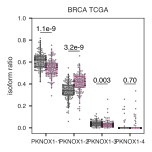

In [96]:
tmp = f_brca_paired_melt[f_brca_paired_melt["gene_name"] == "PKNOX1"]

fig = plt.figure(figsize=(2, 2))

ax = sns.boxplot(data=tmp, x="iso_id", y="value", hue="samp", fliersize=0,
                 palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]})
mimic_r_boxplot(ax)

sns.swarmplot(data=tmp, x="iso_id", y="value", hue="samp",
              palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]}, ax=ax,
              size=1, edgecolor="black", linewidth=0.5, alpha=0.5, split=True)

# annotate w p-vals
ys = [0.87, 0.7, 0.4, 0.4]
for i, iso in enumerate(tmp.iso_id.unique()):
    print(iso)
    padj = dn_data_exp[dn_data_exp["iso_id"]==iso]["wilcox_padj"].iloc[0]
    
    annotate_pval(ax, i-0.2, i+0.2, ys[i], 0, ys[i], padj, PAPER_FONTSIZE)

ax.set_xlabel("")
ax.set_ylabel("isoform ratio")
ax.set_title("BRCA TCGA")
ax.get_legend().remove()
ax.set_ylim((-0.05, 1))

fig.savefig("../figures/BRCA_PKNOX1_boxplot.pdf", dpi="figure", bbox_inches="tight")

KLF7-1
KLF7-203
KLF7-3
KLF7-4
KLF7-5
KLF7-6
KLF7-7
KLF7-8


(-0.05, 1.1)

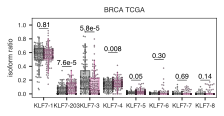

In [61]:
tmp = f_brca_paired_melt[f_brca_paired_melt["gene_name"] == "KLF7"]

fig = plt.figure(figsize=(3, 1.5))

ax = sns.boxplot(data=tmp, x="iso_id", y="value", hue="samp", fliersize=0,
                 palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]})
mimic_r_boxplot(ax)

sns.swarmplot(data=tmp, x="iso_id", y="value", hue="samp",
              palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]}, ax=ax,
              size=1, edgecolor="black", linewidth=0.5, alpha=0.5, split=True)

# annotate w p-vals
tmp = f_brca_filt[f_brca_filt["gene_name"] == "KLF7"]
ys = [0.95, 0.4, 0.9, 0.6, 0.2, 0.5, 0.2, 0.2]
for i, iso in enumerate(tmp.iso_id.unique()):
    print(iso)
    padj = tmp[tmp["iso_id"]==iso]["wilcox_padj"].iloc[0]
    
    annotate_pval(ax, i-0.2, i+0.2, ys[i], 0, ys[i], padj, PAPER_FONTSIZE)

ax.set_xlabel("")
ax.set_ylabel("isoform ratio")
ax.set_title("BRCA TCGA")
ax.get_legend().remove()
ax.set_ylim((-0.05, 1.1))

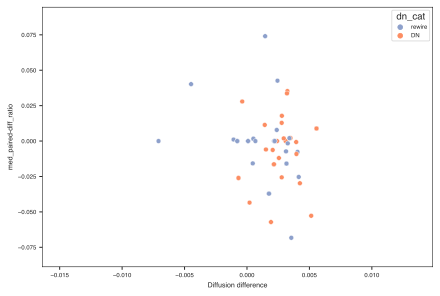

In [94]:
sns.scatterplot(data=dn_data_exp[dn_data_exp["dn_cat"].isin(["rewire", "DN"])], 
                x="Diffusion difference", y="med_paired-diff_ratio", hue="dn_cat",
                palette=pal)

In [93]:
dn_data_exp[dn_data_exp["dn_cat"].isin(["rewire", "DN"])][["tf1p0_id", "dn_cat", "Diffusion difference", "Diffusion P-value",
                                                           "med_paired-diff_ratio", "wilcox_padj"]].sort_values(by="Diffusion difference")

,tf1p0_id,dn_cat,Diffusion difference,Diffusion P-value,med_paired-diff_ratio,wilcox_padj
181,ATF2|2/6|09E05,rewire,-0.007084,0.440660,0.000000,1.597677e-03
408,NFIX|2/4|08G06,rewire,-0.004477,0.369032,0.040191,2.166790e-03
371,TGIF1|1/3|02H07,rewire,-0.001075,0.000964,0.001081,7.488478e-01
382,TCF4|3/9|07C04,rewire,-0.000781,0.004085,0.000000,4.798382e-01
383,TCF4|3/9|07C04,rewire,-0.000781,0.004085,0.000000,4.798382e-01
...,...,...,...,...,...,...
388,TCF4|7/9|07G03,rewire,NaN,NaN,0.000000,1.223849e-01
409,NFIX|3/4|08F05,rewire,NaN,NaN,0.000000,8.198674e-01
410,NFIX|4/4|08D05,DN,NaN,NaN,0.000000,3.356859e-03
426,PKNOX1|2/4|06H05,DN,NaN,NaN,0.063234,3.155443e-09
